## 4.1 Coding an LLM architecture

In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
# Vocabulary size
"context_length": 1024,
# Context length
"emb_dim": 768,# Embedding dimension
"n_heads": 12,# Number of attention heads
"n_layers": 12,# Number of layers
"drop_rate": 0.1,# Dropout rate
"qkv_bias": False# Query-Key-Value bias
}

In [2]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [3]:
import torch
import torch.nn as nn
class DummyTransformerBlock(nn.Module):
    #C
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):
    #D
        return x
class DummyLayerNorm(nn.Module):
    #E
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x

In [4]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]) #A
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        #B
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [6]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [7]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), GELU(), nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)
    def forward(self, x):
        return self.layers(x)

In [8]:
class MultiHeadAttention(nn.Module):
	def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
		super().__init__()
		assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
		self.d_out = d_out
		self.num_heads = num_heads
		self.head_dim = d_out // num_heads
		#A
		self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
		self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
		self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
		self.out_proj = nn.Linear(d_out, d_out)
		#B
		self.dropout = nn.Dropout(dropout)
		self.register_buffer('mask',torch.triu(torch.ones(context_length, context_length), diagonal=1))
	def forward(self, x):
		b, num_tokens, d_in = x.shape
		keys = self.W_key(x)#C
		queries = self.W_query(x)#C
		values = self.W_value(x)#C
		keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) #D
		values = values.view(b, num_tokens, self.num_heads, self.head_dim) #D
		queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)#D
		keys = keys.transpose(1, 2)#E
		queries = queries.transpose(1, 2)#E
		values = values.transpose(1, 2)#E
		attn_scores = queries @ keys.transpose(2, 3)
		#F
		mask_bool = self.mask.bool()[:num_tokens, :num_tokens]#G
		attn_scores.masked_fill_(mask_bool, -torch.inf)#H
		attn_weights = torch.softmax(
		attn_scores / keys.shape[-1]**0.5, dim=-1)
		attn_weights = self.dropout(attn_weights)
		context_vec = (attn_weights @ values).transpose(1, 2) #I
		#J
		context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
		context_vec = self.out_proj(context_vec)
		#K
		return context_vec


#A Reduce the projection dim to match desired output dim
#B Use a Linear layer to combine head outputs
#C Tensor shape: (b, num_tokens, d_out)
#D We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
#E Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
#F Compute dot product for each head
#G Mask truncated to the number of tokens
#H Use the mask to fill attention scores
#I Tensor shape: (b, num_tokens, n_heads, head_dim)
#J Combine heads, where self.d_out = self.num_heads * self.head_dim
#K Add an optional linear projection

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"], num_heads=cfg["n_heads"],
dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        #A
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        # Add the original input back
        shortcut = x
        #B
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        #C
        return x

In [10]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
#A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 4.6 Coding the GPT model

In [11]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        #A
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [12]:
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        #B
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]#C
        probas = torch.softmax(logits, dim=-1)#D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)#E
        idx = torch.cat((idx, idx_next), dim=1)#F
    return idx

## 5.1.1 Using GPT to generate text

In [13]:
import torch
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256,
#A
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
#B
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [14]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [15]:
import tiktoken
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [16]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20480
Tokens: 5146


In [17]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [18]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    #A
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    #B
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=0)
    return dataloader

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)#A
        for i in range(0, len(token_ids) - max_length, stride):#B
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self):
        #C
        return len(self.input_ids)
    def __getitem__(self, idx):
        #D
        return self.input_ids[idx], self.target_ids[idx]

In [20]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [21]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device) #A
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

In [23]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
        #A
    else:
        num_batches = min(num_batches, len(data_loader))
        #B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
            #C
        else:
            break
    return total_loss / num_batches
    #D

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #A
print(device)
model.to(device)
with torch.no_grad():
    #B
    train_loss = calc_loss_loader(train_loader, model, device)
    #C
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

cuda
Training loss: 10.987582842508951
Validation loss: 10.983160018920898


In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    #A
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        #B
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            #C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()#D
            optimizer.step()#E
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                #F
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(
        #G
            model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [26]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()#A
    with torch.no_grad():#B
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [27]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
        # Compact print format
    model.train()

In [28]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) #A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=1,
start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.060, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.158, Val loss 8.339
Every effort moves you,.                                                
Ep 2 (Step 000010): Train loss 6.556, Val loss 7.052
Ep 2 (Step 000015): Train loss 5.926, Val loss 6.601
Every effort moves you, and,, and,, and,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.823, Val loss 6.501
Ep 3 (Step 000025): Train loss 5.391, Val loss 6.382
Every effort moves you, and to the of the of the of the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.594, Val loss 6.280
Ep 4 (Step 000035): Train loss 5.016, Val loss 6.293
Every effort moves you, I had.    "I had been.               "I"I the picture"I had the the honour of the picture and I had been.  
Ep 5 (Step 000040): Train loss 4.119, Val loss 6.158
Every effort moves you know the                                               

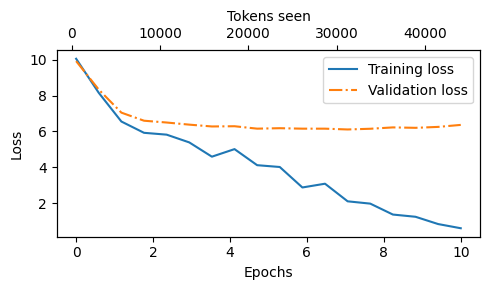

In [29]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()#A
    ax2.plot(tokens_seen, train_losses, alpha=0)#B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [31]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(model=model, idx=text_to_token_ids("Every effort moves you", tokenizer), max_new_tokens=25, context_size=GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"


